In [1]:
from IPython.display import FileLink
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os
import glob
from tqdm import tqdm
from time import time

file_names = []
for dirname, _, filenames in os.walk('E:\\tabular-playground-series-oct-2022\\'):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))

In [2]:
def reduce_mem_usage(df, keep_float16=True):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if keep_float16:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32) 
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file, keep_float16=True):
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df, keep_float16)
    return df

In [3]:
def makedir_check(path):
    exist_dir = os.path.exists(path)
    if exist_dir:
        print("The directory already exists!")
    else:
        os.makedirs(path)
        print(f"The directory, {path}, has been created!")

In [4]:
def delete_files(path, removal='file'):
    if removal=='file':
        files = glob.glob(path)
        for f in files:
            os.remove(f)
        print('Files deleted successfully.')
    if removal=='directory':
        os.removedirs(path)
        print('Directory deleted successfully.')

In [5]:
train_paths = []
for k in file_names:
    if 'train_' in k and 'dtypes' not in k:
        train_paths.append(k)
        
train_paths

['E:\\tabular-playground-series-oct-2022\\train_0.csv',
 'E:\\tabular-playground-series-oct-2022\\train_1.csv',
 'E:\\tabular-playground-series-oct-2022\\train_2.csv',
 'E:\\tabular-playground-series-oct-2022\\train_3.csv',
 'E:\\tabular-playground-series-oct-2022\\train_4.csv',
 'E:\\tabular-playground-series-oct-2022\\train_5.csv',
 'E:\\tabular-playground-series-oct-2022\\train_6.csv',
 'E:\\tabular-playground-series-oct-2022\\train_7.csv',
 'E:\\tabular-playground-series-oct-2022\\train_8.csv',
 'E:\\tabular-playground-series-oct-2022\\train_9.csv',
 'E:\\tabular-playground-series-oct-2022\\feather_data\\train_0_compressed.ftr',
 'E:\\tabular-playground-series-oct-2022\\feather_data\\train_1_compressed.ftr',
 'E:\\tabular-playground-series-oct-2022\\feather_data\\train_2_compressed.ftr',
 'E:\\tabular-playground-series-oct-2022\\feather_data\\train_3_compressed.ftr',
 'E:\\tabular-playground-series-oct-2022\\feather_data\\train_4_compressed.ftr',
 'E:\\tabular-playground-series-oct

In [6]:
makedir_check('feather_data')
makedir_check('parquet_data')

The directory already exists!
The directory already exists!


In [7]:
time_read = {}
size_file = {}
for file_path in tqdm(train_paths):
    times = {}
    sizes = {}

    name_files_ftr =  (
        file_path.split('\\')[-1]
        .replace('.', '_compressed.')
        .replace('csv','ftr')
    )
    name_files_parquet = name_files_ftr.replace('ftr', 'parquet')
    file_only = name_files_ftr.split('_c')[0]

    t1 = time()
    df = pd.read_csv(file_path)
    sizes['memory_csv'] = df.memory_usage(deep=True).sum()/(1024**2)
    times['read_csv'] = time() - t1
    df = reduce_mem_usage(df)

    df.to_feather("feather_data\\"+name_files_ftr)
    t1 = time()
    df = pd.read_feather("feather_data\\"+name_files_ftr)
    sizes['memory_feather'] = df.memory_usage(deep=True).sum()/(1024**2)
    times['read_feather'] = time() - t1

    os.makedirs("parquet_data", exist_ok=True)

    df = pd.read_csv(file_path)
    df= reduce_mem_usage(df, keep_float16=False)
    df.to_parquet("parquet_data\\"+name_files_parquet)

    t1 = time()
    df = pd.read_parquet("parquet_data\\"+name_files_parquet)
    times['read_parquet'] = time() - t1
    sizes['memory_parquet'] = df.memory_usage(deep=True).sum()/(1024**2)

    time_read[file_only] = times
    size_file[file_only] = sizes

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Memory usage of dataframe is 1000.31 MB
Memory usage after optimization is: 245.98 MB
Decreased by 75.4%
Memory usage of dataframe is 1000.31 MB
Memory usage after optimization is: 471.46 MB
Decreased by 52.9%


  3%|██▊                                                                                | 1/30 [00:51<25:07, 51.97s/it]

Memory usage of dataframe is 1009.33 MB
Memory usage after optimization is: 248.20 MB
Decreased by 75.4%
Memory usage of dataframe is 1009.33 MB
Memory usage after optimization is: 475.71 MB
Decreased by 52.9%


  7%|█████▌                                                                             | 2/30 [01:38<22:40, 48.59s/it]

Memory usage of dataframe is 989.19 MB
Memory usage after optimization is: 243.24 MB
Decreased by 75.4%
Memory usage of dataframe is 989.19 MB
Memory usage after optimization is: 466.22 MB
Decreased by 52.9%


 10%|████████▎                                                                          | 3/30 [02:21<20:50, 46.32s/it]

Memory usage of dataframe is 984.12 MB
Memory usage after optimization is: 242.00 MB
Decreased by 75.4%
Memory usage of dataframe is 984.12 MB
Memory usage after optimization is: 463.83 MB
Decreased by 52.9%


 13%|███████████                                                                        | 4/30 [03:05<19:37, 45.29s/it]

Memory usage of dataframe is 985.63 MB
Memory usage after optimization is: 242.37 MB
Decreased by 75.4%
Memory usage of dataframe is 985.63 MB
Memory usage after optimization is: 464.54 MB
Decreased by 52.9%


 17%|█████████████▊                                                                     | 5/30 [03:49<18:41, 44.87s/it]

Memory usage of dataframe is 974.41 MB
Memory usage after optimization is: 239.61 MB
Decreased by 75.4%
Memory usage of dataframe is 974.41 MB
Memory usage after optimization is: 459.25 MB
Decreased by 52.9%


 20%|████████████████▌                                                                  | 6/30 [04:32<17:41, 44.21s/it]

Memory usage of dataframe is 960.55 MB
Memory usage after optimization is: 236.20 MB
Decreased by 75.4%
Memory usage of dataframe is 960.55 MB
Memory usage after optimization is: 452.72 MB
Decreased by 52.9%


 23%|███████████████████▎                                                               | 7/30 [05:14<16:43, 43.61s/it]

Memory usage of dataframe is 981.80 MB
Memory usage after optimization is: 241.43 MB
Decreased by 75.4%
Memory usage of dataframe is 981.80 MB
Memory usage after optimization is: 462.74 MB
Decreased by 52.9%


 27%|██████████████████████▏                                                            | 8/30 [06:00<16:10, 44.12s/it]

Memory usage of dataframe is 1001.45 MB
Memory usage after optimization is: 246.26 MB
Decreased by 75.4%
Memory usage of dataframe is 1001.45 MB
Memory usage after optimization is: 472.00 MB
Decreased by 52.9%


 30%|████████████████████████▉                                                          | 9/30 [06:47<15:47, 45.13s/it]

Memory usage of dataframe is 978.63 MB
Memory usage after optimization is: 240.65 MB
Decreased by 75.4%
Memory usage of dataframe is 978.63 MB
Memory usage after optimization is: 461.24 MB
Decreased by 52.9%


 33%|███████████████████████████▎                                                      | 10/30 [07:34<15:09, 45.47s/it]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 8: invalid start byte

In [8]:
df_test_feather = import_data('E:\\tabular-playground-series-oct-2022\\test.csv')
df_test_parquet = import_data('E:\\tabular-playground-series-oct-2022\\test.csv',keep_float16=False)

df_test_feather.to_feather('feather_data\\test_compressed.ftr')
df_test_parquet.to_parquet('parquet_data\\test_compressed.parquet')

Memory usage of dataframe is 294.21 MB
Memory usage after optimization is: 74.89 MB
Decreased by 74.5%
Memory usage of dataframe is 294.21 MB
Memory usage after optimization is: 147.11 MB
Decreased by 50.0%


In [9]:
time_taken_read = pd.DataFrame(time_read).T

time_taken_read = time_taken_read.apply(lambda x: x.round(3))
time_taken_read.columns = ['time_to_read_csv(seconds)', 'time_to_read_feather(seconds)', 'time_to_read_parquet(seconds)']

In [10]:
time_taken_read

,time_to_read_csv(seconds),time_to_read_feather(seconds),time_to_read_parquet(seconds)
train_0,16.526,0.296,1.329
train_1,14.396,0.256,0.469
train_2,12.607,0.243,0.453
train_3,13.546,0.252,0.453
train_4,13.464,0.281,0.462
train_5,12.940,0.259,0.406
train_6,12.929,0.234,0.406
train_7,12.855,0.242,0.484
train_8,13.633,0.301,0.578
train_9,13.837,0.325,0.560


In [11]:
size_of_files = pd.DataFrame(size_file).T
size_of_files = size_of_files.apply(lambda x: x.round(2))
size_of_files.columns = ['memory_csv(MB)', 'memory_feather(MB)', 'memory_parquet(MB)']
size_of_files

,memory_csv(MB),memory_feather(MB),memory_parquet(MB)
train_0,1090.24,245.98,471.46
train_1,1100.07,248.20,475.71
train_2,1078.42,243.24,466.22
train_3,1073.71,242.00,463.83
train_4,1074.69,242.37,464.54
train_5,1062.84,239.61,459.25
train_6,1047.93,236.20,452.72
train_7,1070.73,241.43,462.74
train_8,1092.01,246.26,472.00
train_9,1066.73,240.65,461.24


In [12]:
time_taken_read.sort_index(inplace=True)
size_of_files.sort_index(inplace=True)

In [13]:
time_taken_read.reset_index(inplace=True)
size_of_files.reset_index(inplace=True)

In [14]:
time_taken_read.columns= ['file_name', 'time_to_read_csv(seconds)', 'time_to_read_feather(seconds)',
       'time_to_read_parquet(seconds)']
size_of_files.columns = ['file_name', 'memory_csv(MB)', 'memory_feather(MB)', 'memory_parquet(MB)']

In [15]:
proportion_files = (size_of_files[['memory_csv(MB)', 'memory_feather(MB)','memory_parquet(MB)']]).div(size_of_files['memory_csv(MB)'], axis=0)
proportion_files['file_name'] = size_of_files['file_name']

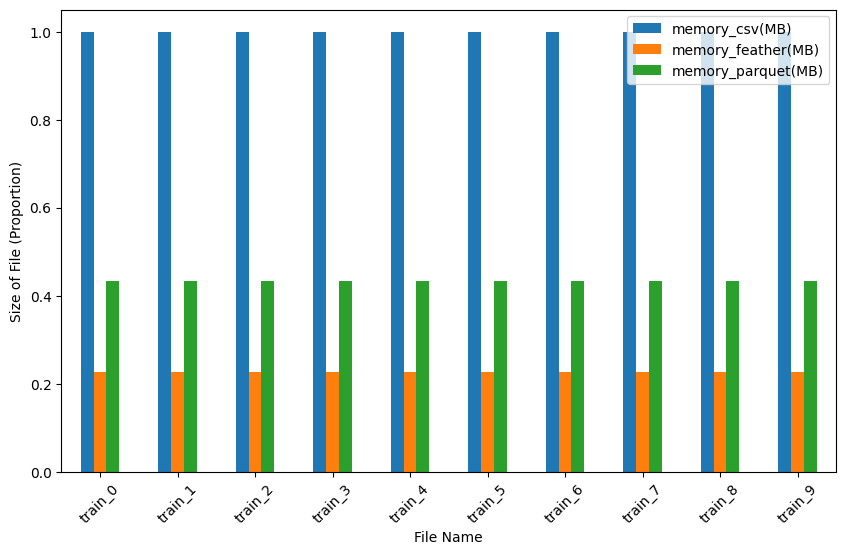

In [16]:
proportion_files.plot(x='file_name',
                      y=['memory_csv(MB)', 'memory_feather(MB)','memory_parquet(MB)'],
                      kind='bar',
                     figsize=(10,6))
plt.xlabel("File Name")
plt.ylabel("Size of File (Proportion)")
plt.xticks(rotation=45);

In [17]:
(
    proportion_files[['memory_feather(MB)','memory_parquet(MB)']]
    .apply(lambda x: round((1-x)*100,2))
    .mean(axis=0).round(2)
)

memory_feather(MB)    77.45
memory_parquet(MB)    56.78
dtype: float64

In [18]:
print(f"Mean speed-up in time taken to read feather compared to csv: {round((time_taken_read['time_to_read_csv(seconds)']/time_taken_read['time_to_read_feather(seconds)']).mean(),2)} times")
print(f"Mean speed-up in time taken to read feather compared to csv: {round((time_taken_read['time_to_read_csv(seconds)']/time_taken_read['time_to_read_parquet(seconds)']).mean(),2)} times")

Mean speed-up in time taken to read feather compared to csv: 51.18 times
Mean speed-up in time taken to read feather compared to csv: 26.86 times


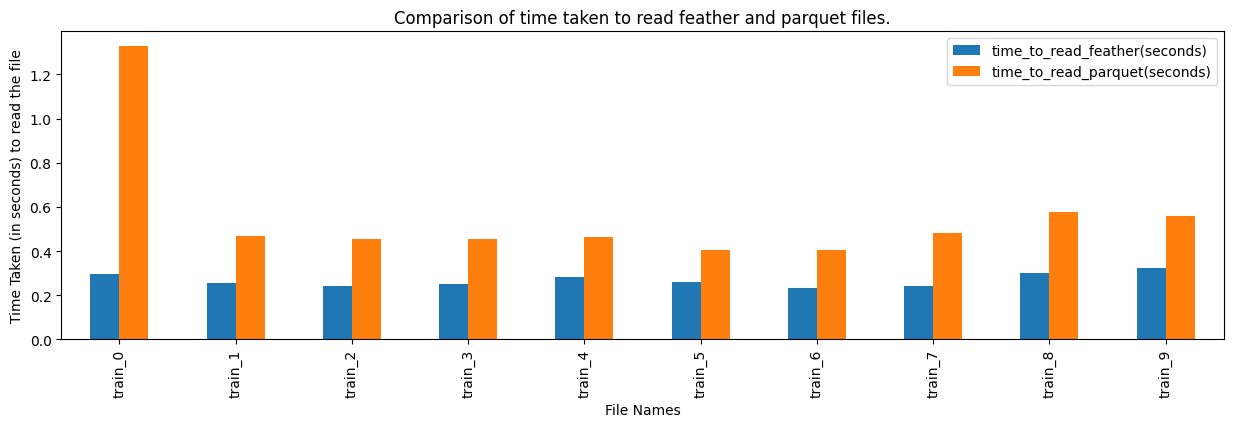

In [19]:
time_taken_read.plot(x='file_name', 
                     y =  ['time_to_read_feather(seconds)',
                          'time_to_read_parquet(seconds)'], 
                     kind='bar', figsize=(15,4))
plt.xlabel('File Names')
plt.ylabel('Time Taken (in seconds) to read the file')
plt.title('Comparison of time taken to read feather and parquet files.')
plt.xticks(rotation=90);

In [20]:
import gc
import random

from pathlib import Path
from fastai.tabular.all import *
import fastai.losses as loss

In [21]:
features = [
    'ball_pos_x', 'ball_pos_y','ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 
    'p0_pos_x', 'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost', 'p0_na',
    'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z', 'p1_boost', 'p1_na',
    'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y', 'p2_vel_z', 'p2_boost', 'p2_na',
    'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x', 'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p3_na',
    'p4_pos_x', 'p4_pos_y', 'p4_pos_z', 'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p4_na',
    'p5_pos_x', 'p5_pos_y', 'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost', 'p5_na',
    'boost0_timer', 'boost1_timer', 
    'boost2_timer', 'boost3_timer',
    'boost4_timer', 'boost5_timer']

In [22]:
features_x_pos = [pos for pos, feature in enumerate(features) if feature.endswith('_x')]
features_y_pos = [pos for pos, feature in enumerate(features) if feature.endswith('_y')]

In [23]:
targets = [
    'team_A_scoring_within_10sec',
    'team_B_scoring_within_10sec']

In [24]:
%%time
DEBUG = False
input_path = Path('E:\\tabular-playground-series-oct-2022\\feather_data')

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
def fe(x):
    x['p0_na'] = x['p0_pos_x'].isna().astype('int8')
    x['p1_na'] = x['p1_pos_x'].isna().astype('int8')
    x['p2_na'] = x['p2_pos_x'].isna().astype('int8')
    x['p3_na'] = x['p3_pos_x'].isna().astype('int8')
    x['p4_na'] = x['p4_pos_x'].isna().astype('int8')
    x['p5_na'] = x['p5_pos_x'].isna().astype('int8')
    for feature in features:
        if feature.endswith('_na'):
            continue
        if feature.endswith('_x'):
            x[feature] = (x[feature] / 82).fillna(0).astype('float16')
        if feature.endswith('_y'):
            x[feature] = (x[feature] / 120).fillna(0).astype('float16')
        if feature.endswith('_z'):
            x[feature] = (x[feature] / 40).fillna(0).astype('float16')
        if feature.endswith('_boost'):
            x[feature] = (x[feature] / 100).fillna(0).astype('float16')
        if feature.endswith('_timer'):
            x[feature] = (-x[feature] / 100).astype('float16')
    return x

In [26]:
def read_train():
    dfs = []
    for i in range(10):
        dfs.append(fe(pd.read_feather(input_path / f'train_{i}_compressed.ftr')))
    result = pd.concat(dfs)
    if DEBUG:
        result = result.sample(frac=0.05)
    return result

In [27]:
def read_test():
    return fe(pd.read_feather(input_path / 'test_compressed.ftr'))

In [28]:
df_train = read_train()
gc.collect()

0

In [29]:
print(f'Train Rows = {len(df_train):,}  ' 
      f'Memory Usage = {df_train.memory_usage(deep=True).sum() / (1024 * 1024):4.1f} Mb' '\n')

Train Rows = 21,198,036  Memory Usage = 2708.9 Mb



In [30]:
game_nums = df_train['game_num'].unique()
train_game_nums = random.sample(list(game_nums), int(len(game_nums) * 0.80))

In [31]:
train_feature_tensor = torch.tensor(
    df_train.query("game_num in @train_game_nums")[features].to_numpy())
train_target_tensor  = torch.tensor(
    df_train.query("game_num in @train_game_nums")[targets].to_numpy())

In [32]:
valid_feature_tensor = torch.tensor(
    df_train.query("game_num not in @train_game_nums")[features].to_numpy())
valid_target_tensor  = torch.tensor(
    df_train.query("game_num not in @train_game_nums")[targets].to_numpy())

In [33]:
gc.collect()

6

In [34]:
if torch.cuda.is_available():
    train_feature_tensor = train_feature_tensor.cuda()
    train_target_tensor  = train_target_tensor.cuda()
    valid_feature_tensor = valid_feature_tensor.cuda()
    valid_target_tensor  = valid_target_tensor.cuda()

In [35]:
del df_train
gc.collect()

0

In [36]:
def fe_goal_distance(ball):
    dist_a = ((ball[:,0:1] - 0) ** 2 + (ball[:,1:2] - 1) ** 2 + (ball[:,2:3] - 0) ** 2) ** 0.5 / 2
    dist_b = ((ball[:,0:1] - 0) ** 2 + (ball[:,1:2] + 1) ** 2 + (ball[:,2:3] - 0) ** 2) ** 0.5 / 2 
    return dist_a, dist_b
    
def fe_dist_ball_player(ball, player):
    dist = ((
        (ball[:,0:1] - player[:,0:1]) ** 2 + 
        (ball[:,1:2] - player[:,1:2]) ** 2 + 
        (ball[:,2:3] - player[:,2:3]) ** 2) ** 0.5) / 12
    return dist

def fe_speed_of_thing(thing):
    return (thing[:, 3:4] ** 2 + thing[:, 4:5] ** 2 + thing[:, 5:6] ** 2) ** 0.5

def augment_fe(empty, X, Y):
    ball = X[:, :6]
    p0 = X[:,  6:14]
    p1 = X[:, 14:22]
    p2 = X[:, 22:30]
    p3 = X[:, 30:38]
    p4 = X[:, 38:46]
    p5 = X[:, 46:54]
    boosts = X[:, 54:]
    
    goal_a, goal_b = fe_goal_distance(ball)
    
    p0d = fe_dist_ball_player(ball, p0)
    p1d = fe_dist_ball_player(ball, p1)
    p2d = fe_dist_ball_player(ball, p2)
    p3d = fe_dist_ball_player(ball, p3)
    p4d = fe_dist_ball_player(ball, p4)
    p5d = fe_dist_ball_player(ball, p5)
    
    ball_s = fe_speed_of_thing(ball)
    p0s = fe_speed_of_thing(p0)
    p1s = fe_speed_of_thing(p1)
    p2s = fe_speed_of_thing(p2)
    p3s = fe_speed_of_thing(p3)
    p4s = fe_speed_of_thing(p4)
    p5s = fe_speed_of_thing(p5)
    
    new_X = torch.cat([
        ball, p0, p1, p2, p3, p4, p5, boosts,
        goal_a, goal_b,
        ball_s,
        p0d, p1d, p2d, p3d, p4d, p5d,
        p0s, p1s, p2s, p3s, p4s, p5s
    ], dim=1)
    
    return empty, new_X, Y

In [37]:
def augment_mirror(empty, X, Y):
    positions = X[:,:54]
    positions[:, features_x_pos] = -positions[:, features_x_pos]
    positions[:, features_y_pos] = -positions[:, features_y_pos]
    
    ball = positions[:, :6]
    p0 = positions[:,  6:14]
    p1 = positions[:, 14:22]
    p2 = positions[:, 22:30]
    p3 = positions[:, 30:38]
    p4 = positions[:, 38:46]
    p5 = positions[:, 46:54]
    
    players = torch.cat([p3, p4, p5, p0, p1, p2], dim=1)
    boosts = X[:, [59, 58, 57, 56, 55, 54]]
    
    flip_X = torch.cat([ball, players, boosts], dim=1)
    flip_Y = Y[:, :, [1,0]]
    
    return empty, flip_X, flip_Y

In [38]:
def augment_flip_x(empty, X, Y):
    positions = X[:,:54]
    positions[:, features_x_pos] = -positions[:, features_x_pos]
    boosts = X[:, [55, 54, 57, 56, 59, 58]]
    
    flip_X = torch.cat([positions, boosts], dim=1)
    
    return empty, flip_X, Y

In [39]:
def augment_shuffle(empty, X, Y):
    ball = X[:, :6]
    p0 = X[:,  6:14]
    p1 = X[:, 14:22]
    p2 = X[:, 22:30]
    p3 = X[:, 30:38]
    p4 = X[:, 38:46]
    p5 = X[:, 46:54]
    boosts = X[:, 54:]
    
    pA = torch.cat(random.sample([p0, p1, p2], 3), dim=1)
    pB = torch.cat(random.sample([p3, p4, p5], 3), dim=1)
    
    shuffled_X = torch.cat([ball, pA, pB, boosts], dim=1)
    
    return empty, shuffled_X, Y
 
class BespokeDataset:
    def __init__(self, feature_tensor, targets, augment=False):
        store_attr()
        self.n_inp = 2
    def __getitem__(self, idx):
        batch = torch.empty(0), self.feature_tensor[idx].float(), self.targets[idx, None]
        if self.augment:
            batch = augment_shuffle(*batch)
            if random.random() > 0.5:
                batch = augment_mirror(*batch)
            if random.random() > 0.5:
                batch = augment_flip_x(*batch)
        batch = augment_fe(*batch)
        return batch
    
    def __len__(self):
        return len(self.feature_tensor)
    
class BespokeDL(DataLoader):
    def __iter__(self):
        if self.shuffle:
            self.__idxs = torch.tensor(np.random.permutation(range(0,self.n)))
        else:
            self.__idxs = torch.tensor(range(0,self.n))
        for batch_start in range(0, self.n, self.bs):
            if batch_start + self.bs > self.n and self.drop_last:
                return 
            indices = self.__idxs[batch_start:batch_start+self.bs]
            yield self.dataset[indices]

In [40]:
ds_train = BespokeDataset(train_feature_tensor, train_target_tensor, augment=True)
ds_val   = BespokeDataset(valid_feature_tensor, valid_target_tensor, augment=True)

dls = DataLoaders.from_dsets(ds_train, ds_val, bs=4096, dl_type=BespokeDL, num_workers=0, shuffle=True)

In [41]:
len(ds_train), len(ds_val)

(16938140, 4259896)

In [42]:
model = TabularModel(
    emb_szs={}, 
    n_cont=len(features) + 15,
    ps=0.3, out_sz=len(targets), 
    layers=[512, 256, 128, 64], y_range=(0,1))
if torch.cuda.is_available():
    model = model.cuda()
    
learn = Learner(dls, model, loss_func=loss.BCELossFlat())
model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=75, out_features=512, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=512, out_features=256, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=256, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    )
    (3): LinBnDrop(
      (0): Linear(i

In [43]:
%%time
fit = learn.fit(2 if DEBUG else 25, 1e-3)
ds_train = BespokeDataset(
    torch.cat([train_feature_tensor, valid_feature_tensor]), 
    torch.cat([train_target_tensor, valid_target_tensor]), augment=True)

ds_val   = BespokeDataset(valid_feature_tensor, valid_target_tensor, augment=True)

dls = DataLoaders.from_dsets(ds_train, ds_val, bs=4096, dl_type=BespokeDL, num_workers=0, shuffle=True)

model = TabularModel(
    emb_szs={}, n_cont=len(features) + 15, 
    ps=0.3, out_sz=len(targets), 
    layers=[512, 256, 128, 64], y_range=(0,1))
if torch.cuda.is_available():
    model = model.cuda()
    
learn = Learner(dls, model, loss_func=loss.BCELossFlat())

fit = learn.fit(2 if DEBUG else 75, 1e-3)

epoch,train_loss,valid_loss,time
0,0.194897,0.191461,06:14
1,0.191508,0.190102,05:57
2,0.189676,0.188891,05:59
3,0.189609,0.188300,05:56
4,0.188459,0.187856,05:56
5,0.188525,0.187420,05:55
6,0.188051,0.187300,06:03
7,0.189418,0.186918,05:58
8,0.187764,0.186907,05:57
9,0.188748,0.186606,05:56


epoch,train_loss,valid_loss,time
0,0.191707,0.190390,07:17
1,0.190389,0.188833,06:58
2,0.188321,0.187851,07:18
3,0.189780,0.187308,06:31
4,0.188426,0.186887,06:19
5,0.186871,0.186510,06:39
6,0.189507,0.186347,06:41
7,0.188098,0.186179,06:52
8,0.189010,0.185950,07:07
9,0.188297,0.185875,07:18


CPU times: total: 1d 20h 51min 47s
Wall time: 11h 21min 15s


In [44]:
df_test = read_test()
gc.collect()

ds_test = BespokeDataset(torch.tensor(df_test[features].to_numpy()), torch.zeros(len(df_test), 2))
test_dl = learn.dls.test_dl(ds_test)
test_dl.augment = False
test_dl.shuffle = False 
preds, _ = learn.get_preds(dl=test_dl)

In [45]:
submission = pd.read_csv('E:\\tabular-playground-series-oct-2022\\sample_submission.csv')
submission.iloc[:, 1:] = preds.numpy()
submission.to_csv('submission.csv', index=False)
submission.head()

,id,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,0,0.041928,0.035123
1,1,0.006296,0.130213
2,2,0.022625,0.088081
3,3,0.046429,0.027339
4,4,0.018271,0.036721
